In [1]:
import numpy as np
import pandas as pd
import os 
import six
import seaborn as sn
import matplotlib.pyplot as plt
from utils.test_util import calc_divgenerce
from utils.data_util import save_samples, extract_data, load_inception_net
from aggre_results import *

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.






In [2]:
import os
path = os.getcwd()
import sys
sys.path.append(path+'/../../')
#import prd.prd_score as prd

In [3]:
import matplotlib as mtp
mtp.rcParams['pdf.fonttype'] = 42
mtp.rcParams['ps.fonttype'] = 42

In [4]:
%matplotlib inline

In [5]:
def aggreate_divergence(path):
    sd = os.listdir(path)
    data = []
    for s in sd:
        print(s)
        if '.' in s:
            continue

        ds = np.loadtxt(path+s+'/divergence_compare.csv',delimiter=',')
        #ds = np.loadtxt(path+s+'/kl.csv',delimiter=',')
        data.append(ds)
    n = len(data)
    data = np.vstack(data)
    data = data.reshape(n,-1,data.shape[-1])
    return data

In [6]:
def aggreate_score(path,stype='fid',file_id=[0]):
    sd = os.listdir(path)
    data = []
    for s in sd:
        print(s)
        if '.' in s:
            continue
        #print(path+s+'/'+stype+'.csv')
        if stype in ['prd_seg','prd_half']:
            for fi in file_id:
                #print('fi',fi)
                ds = np.loadtxt(os.path.join(path,s)+'/'+stype+str(fi)+'.csv',delimiter=',')
                data.append(ds)
                #print(len(data))
        else:
            ds = np.loadtxt(os.path.join(path,s)+'/'+stype+'.csv',delimiter=',')
        #print(ds.shape)
        if stype in ['fid','kl','prd']:
            #print('load score',ds)
            data.append(ds)
            
        elif stype == 'kid':
            if len(ds.shape) > 1:
                data.append(ds[:,0])
            else:
                data.append(ds[0])
    n = len(data)
    #print(n)
    if 'prd' not in stype:
        data = np.vstack(data)
        data = data.reshape(n,data.shape[-1])
        
    return data

In [7]:
def get_divergence(data,type='kl'):
    if type == 'kl':
        t = 0
        e = 1
    elif type == 'tv':
        t = 5
        e = 6
    elif type == 'chi':
        t = 7
        e = 8
        
    true_mean = np.mean(data[:,t,:],axis=0)
    true_std = np.std(data[:,t,:],axis=0)
    est_mean = np.mean(data[:,e,:],axis=0)
    est_std = np.std(data[:,e,:],axis=0)
    
    return true_mean,true_std,est_mean,est_std

In [8]:
def get_divergence_err(data,type='kl'):
    if type == 'kl':
        t = 0
        e = 1
    elif type == 'tv':
        t = 5
        e = 6
    elif type == 'chi':
        t = 7
        e = 8
        
    true_mean = np.mean(data[:,t,:],axis=0)
    true_std = np.std(data[:,t,:],axis=0)
    est_err_mean = np.mean(np.abs(data[:,e,:]-true_mean),axis=0)
    est_err_std = np.std(np.abs(data[:,e,:]-true_mean),axis=0)
    
    return true_mean,true_std,est_err_mean,est_err_std

In [9]:
def get_ratio_err(data,type='mae'):
    rt = []
    for ds in data:
        rt_s = []
        for ds_t in ds:
            if 'log' not in type: 
                estd = np.exp(ds_t[:,1])
                true = np.exp(ds_t[:,2])
            else:
                estd = ds_t[:,1]
                true = ds_t[:,2]
            if 'mae' in type:
                err = np.mean(np.abs(estd-true))
            elif 'mse' in type:
                err = np.mean(np.square(estd-true))
                    
            rt_s.append(err)
        rt.append(rt_s)
    return rt

In [10]:
def aggregate_ratio(path,T=10):
    sd = os.listdir(path)
    data = []
    for s in sd:
        print(s)
        if '.' in s:
            continue
        dt = []
        for t in range(T):
            try:
                ds = pd.read_csv(path+s+'/sample_ratios_t_t'+str(t+1)+'.csv').values            
                dt.append(ds)
            except FileNotFoundError:
                continue
        data.append(dt)
    return data

In [11]:
def cal_div_by_ratio(div_type,paths,T=10,S=5,condition=False):
    div_means,div_stds = [],[]
    for p in paths:
        print(p)
        data = aggregate_ratio(p,T)
        divs=[]
        true_divs=[]
        for s in range(S):
            if T>1:
                ds = []
                true = []
                for t in range(T):
                    #print(s,t)
                    rd = data[s][t]
                    
                    samples_c = one_hot_encoder(rd[:,-1],T) if condition else None
                    div = calc_divgenerce(div_type,[rd[:,1]],samples_c)
                    true_div = calc_divgenerce(div_type,[rd[:,2]],samples_c)
                    #print(div)
                    if condition:
                        ds.append(div[0][:t+1].mean())
                        true.append(true_div[0][:t+1].mean())
                    else:
                        ds.append(div[0])
                        true.append(true_div[0])
                    #print(ds[-1])
                divs.append(ds)
                true_divs.append(true)
            else:
                div = calc_divgenerce(div_type,[data[s]])
                divs.append(div)

        divs=np.vstack(divs)
        d_mean = np.mean(divs,axis=0)
        d_std = np.std(divs,axis=0)
        div_means.append(d_mean)
        div_stds.append(d_std)
    return div_means,div_stds,np.array(true_divs)

In [12]:
def aggregate_paths(paths,ftype='div',file_id=[0]):
    data = []
    for p in paths:
        if ftype=='div':
            d = aggreate_divergence(p)
        elif ftype in ['fid','kid','kl','prd','prd_seg','prd_half']:
            d = aggreate_score(p,ftype,file_id)
        data.append(d)
    return data

In [82]:
t_num = 10
paths = ['../results/cond_cl_d64_s50000_kl/dre_t10/','../results/cond_cl_d64_s50000_kl/cdre_t10/']
#paths = ['../results/cl_d64_s50000_kl/cdre_t5/']
#['../results/cl_d100_s50000_kl/cdre/lam100/b2000/','../results/cl_d100_s50000_kl/cdre/lam10/b2000/increase/','../results/cl_d100_s50000_kl/cdre/lam1/b2000/increase/']
#['../results/cl_d100_s10000_kl/KL/cdre/','../results/cl_d100_s10000_kl/KL/dre/','../results/cl_d100_s10000_kl/hellinger/cdre/','../results/cl_d100_s10000_kl/hellinger/dre/'] 

In [85]:
kl_means,kl_stds = [],[]
for path in paths:
    data = aggreate_divergence(path)
    true_kl_mean,true_kl_std,kl_mean,kl_std = get_divergence(data,type='kl')
    kl_means.append(kl_mean)
    kl_stds.append(kl_std)


cond_cl_ratio_test_d64_sd1_Thu-Aug-13-225847-2020
cond_cl_ratio_test_d64_sd7_Fri-Aug-14-011030-2020
cond_cl_ratio_test_d64_sd2_Thu-Aug-13-231939-2020
cond_cl_ratio_test_d64_sd6_Fri-Aug-14-004859-2020
cond_cl_ratio_test_d64_sd3_Thu-Aug-13-234002-2020
cond_cl_ratio_test_d64_sd9_Fri-Aug-14-014635-2020
cond_cl_ratio_test_d64_sd5_Fri-Aug-14-002904-2020
cond_cl_ratio_test_d64_sd4_Fri-Aug-14-000537-2020
cond_cl_ratio_test_d64_sd8_Fri-Aug-14-012734-2020
cond_cl_ratio_test_d64_sd0_Thu-Aug-13-223807-2020
cond_cl_ratio_test_d64_sd7_Fri-Aug-14-035201-2020
cond_cl_ratio_test_d64_sd6_Fri-Aug-14-034217-2020
cond_cl_ratio_test_d64_sd8_Fri-Aug-14-040219-2020
cond_cl_ratio_test_d64_sd9_Fri-Aug-14-042125-2020
cond_cl_ratio_test_d64_sd1_Fri-Aug-14-020729-2020
cond_cl_ratio_test_d64_sd4_Fri-Aug-14-024924-2020
cond_cl_ratio_test_d64_sd0_Thu-Aug-13-220431-2020
cond_cl_ratio_test_d64_sd3_Fri-Aug-14-023504-2020
cond_cl_ratio_test_d64_sd5_Fri-Aug-14-030753-2020
cond_cl_ratio_test_d64_sd2_Fri-Aug-14-021737-2020


In [64]:
#kl_means[0] = [kl_means[0][i*2+1] for i in range(10)]
#kl_stds[0] = [kl_stds[0][i*2+1] for i in range(10)]

In [21]:

div_type = 'KL'
div_means, div_stds, true_divs = cal_div_by_ratio(div_type,paths,T=t_num)

../results/cond_cl_d64_s50000_kl/dre_t10/
cond_cl_ratio_test_d64_sd1_Thu-Aug-13-225847-2020
cond_cl_ratio_test_d64_sd7_Fri-Aug-14-011030-2020
cond_cl_ratio_test_d64_sd2_Thu-Aug-13-231939-2020
cond_cl_ratio_test_d64_sd6_Fri-Aug-14-004859-2020
cond_cl_ratio_test_d64_sd3_Thu-Aug-13-234002-2020
cond_cl_ratio_test_d64_sd9_Fri-Aug-14-014635-2020
cond_cl_ratio_test_d64_sd5_Fri-Aug-14-002904-2020
cond_cl_ratio_test_d64_sd4_Fri-Aug-14-000537-2020
cond_cl_ratio_test_d64_sd8_Fri-Aug-14-012734-2020
cond_cl_ratio_test_d64_sd0_Thu-Aug-13-223807-2020
../results/cond_cl_d64_s50000_kl/cdre_t10/
cond_cl_ratio_test_d64_sd7_Fri-Aug-14-035201-2020
cond_cl_ratio_test_d64_sd6_Fri-Aug-14-034217-2020
cond_cl_ratio_test_d64_sd8_Fri-Aug-14-040219-2020
cond_cl_ratio_test_d64_sd9_Fri-Aug-14-042125-2020
cond_cl_ratio_test_d64_sd1_Fri-Aug-14-020729-2020
cond_cl_ratio_test_d64_sd4_Fri-Aug-14-024924-2020
cond_cl_ratio_test_d64_sd0_Thu-Aug-13-220431-2020
cond_cl_ratio_test_d64_sd3_Fri-Aug-14-023504-2020
cond_cl_ratio_t

In [65]:
err_means, err_stds = [], []
ratios=[]
for path in paths:
    data = aggregate_ratio(path,T=t_num)
    err = get_ratio_err(data,type='logmae')
    err = np.array(err)
    err_means.append(np.mean(err,axis=0))
    err_stds.append(np.std(err,axis=0))
    ratios.append(data)

cl_ratio_test_d64_Wed-Aug-12-021540-2020
cl_ratio_test_d64_Wed-Aug-12-023440-2020
cl_ratio_test_d64_Wed-Aug-12-022430-2020
cl_ratio_test_d64_Wed-Aug-12-022019-2020
cl_ratio_test_d64_Tue-Aug-11-225541-2020
cl_ratio_test_d64_Wed-Aug-12-022945-2020
cl_ratio_test_d64_Wed-Aug-12-021042-2020
cl_ratio_test_d64_Wed-Aug-12-023947-2020
cl_ratio_test_d64_Wed-Aug-12-024840-2020
cl_ratio_test_d64_Wed-Aug-12-024405-2020
cl_ratio_test_d64_Wed-Aug-12-013540-2020
cl_ratio_test_d64_Wed-Aug-12-004701-2020
cl_ratio_test_d64_Wed-Aug-12-002422-2020
cl_ratio_test_d64_Wed-Aug-12-015856-2020
cl_ratio_test_d64_Wed-Aug-12-010027-2020
cl_ratio_test_d64_Wed-Aug-12-012139-2020
cl_ratio_test_d64_Wed-Aug-12-001244-2020
cl_ratio_test_d64_Tue-Aug-11-220539-2020
cl_ratio_test_d64_Wed-Aug-12-003632-2020
cl_ratio_test_d64_Wed-Aug-12-011011-2020
cl_ratio_test_d64_Tue-Aug-11-222334-2020
cl_ratio_test_d64_Wed-Aug-12-014701-2020


In [66]:
#err_means[0] = [err_means[0][i*2+1] for i in range(10)]
#err_stds[0] = [err_stds[0][i*2+1] for i in range(10)]

In [124]:
np.mean(np.exp(data[0][9][:,1])), np.mean(np.exp(data[0][9][:,2]))

(1.0000004560983455, 0.053556936261592046)

In [30]:
data[4][9][1]

array([-1.7013485 , -1.7013485 , -1.17590384, -1.17590384])

In [31]:
np.median(np.abs(np.exp(data[0][9][:,1]) - np.exp(data[0][9][:,2])))

0.2518910006640994

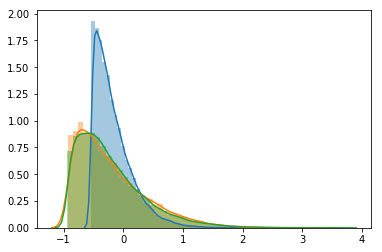

In [32]:
sn.distplot(data[0][4][:,2])
for data in ratios:
    sn.distplot(data[0][4][:,1])

In [42]:
#err_means2 = err_means
#err_stds2 = err_stds

In [201]:
len(true_divs[0])

20

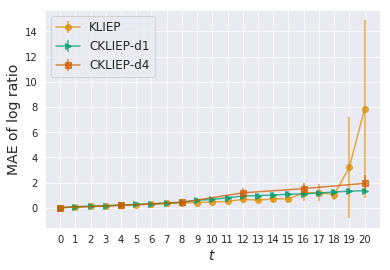

In [75]:

T=np.arange(t_num+1)
T2=np.arange(0,t_num+1,4) 
sn.set_style('darkgrid')
cmp = sn.color_palette("colorblind")
markers = ['o','>','s','*']
#T = np.arange(1,len(true_kl_mean)+1)
#plt.plot(T,true_kl_mean,color=cmp[0]) 
for i,(err_mean,err_std) in enumerate(zip(err_means,err_stds)):
    plt.errorbar(T,[0]+list(err_mean),yerr=[0]+list(err_std),alpha=0.75,marker=markers[i],color=cmp[i+1])
    #plt.plot(T,err_mean,color=cmp[i],marker=markers[i])
    #plt.fill_between(T,err_mean-err_std,err_mean+err_std,alpha=0.3,color=cmp[i])
i+=1
for j,(err_mean,err_std) in enumerate(zip(err_means2,err_stds2)):
    plt.errorbar(T2,[0]+list(err_mean),yerr=[0]+list(err_std),alpha=0.75,marker=markers[i],color=cmp[i+1])
    
#plt.errorbar(T,true_kl_mean,marker='.')
#plt.errorbar(T,kl_mean,marker='.')
#plt.legend([r'$KL^{*}$',r'${KL}_{cdre}:\lambda_c=200$',r'${KL}_{cdre}:\lambda_c=100$',r'${KL}_{cdre}:\lambda_c=10$'],fontsize=14)
plt.legend([r'KLIEP',r'CKLIEP-d1',r'CKLIEP-d4'],fontsize=12,loc=2)
#plt.legend([r'CDRE-$\lambda_c =100$',r'CDRE-$\lambda_c =10$',r'CDRE-$\lambda_c =1$'],fontsize=14,loc=0)
#plt.legend(['CDRE','DRE'])
plt.xlabel(r'$t$',fontsize=14)
plt.ylabel('MAE of log ratio',fontsize=14)
plt.xticks(T)
#plt.savefig('../results/cl_d64_s50000_kl/logr_MAE.pdf')

In [43]:
#kl_means2 = kl_means
#kl_stds2 = kl_stds

<ErrorbarContainer object of 3 artists>

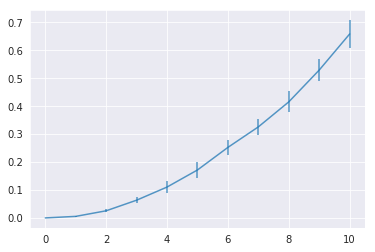

In [88]:
plt.errorbar(T,[0]+list(kl_mean),yerr=[0]+list(kl_std),alpha=0.75)

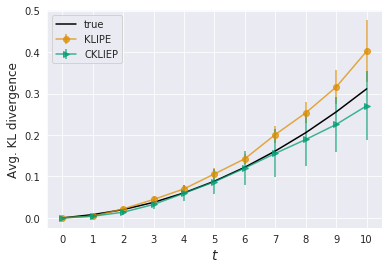

In [89]:
T=np.arange(t_num+1)
T2=np.arange(0,t_num+1,4)
sn.set_style('darkgrid')
cmp = sn.color_palette("colorblind")
markers = ['o','>','s','*','.']
#T0 = np.arange(1,len(true_kl_mean)+1)
plt.plot(T,[0]+list(true_kl_mean),color='k') 
for i,(kl_mean,kl_std) in enumerate(zip(kl_means,kl_stds)):
    plt.errorbar(T,[0]+list(kl_mean),yerr=[0]+list(kl_std),alpha=0.75,marker=markers[i],color=cmp[i+1])
    #plt.plot(T,[0]+list(kl_mean),color=cmp[i+1],marker=markers[i+1])
    #plt.fill_between(T,[0]+list(kl_mean-kl_std),[0]+list(kl_mean+kl_std),alpha=0.3,color=cmp[i+1])
i+=1
#for j,(kl_mean,kl_std) in enumerate(zip(kl_means2,kl_stds2)):
    #plt.errorbar(T2,[0]+list(kl_mean),yerr=[0]+list(kl_std),alpha=0.75,marker=markers[i],color=cmp[i+1])
    #plt.plot(T2,[0]+list(kl_mean),color=cmp[i+1],marker=markers[i+1])
    #plt.fill_between(T2,[0]+list(kl_mean-kl_std),[0]+list(kl_mean+kl_std),alpha=0.3,color=cmp[i+1])
    
#plt.errorbar(T,true_kl_mean,marker='.')
#plt.errorbar(T,kl_mean,marker='.')
#plt.legend([r'$KL^{*}$',r'${KL}_{cdre}:\lambda_c=200$',r'${KL}_{cdre}:\lambda_c=100$',r'${KL}_{cdre}:\lambda_c=10$'],fontsize=14)
#plt.legend(['true',r'CDRE-$\lambda_c =100$',r'CDRE-$\lambda_c =10$',r'CDRE-$\lambda_c =1$'],fontsize=14,loc=2)
plt.legend(['true',r'KLIPE',r'CKLIEP',r'CKLIEP-d4'],loc=2)
plt.xlabel(r'$t$',fontsize=14)
plt.ylabel(r'Avg. KL divergence',fontsize=12)
#plt.ylabel(r'Total variation distance',fontsize=12)
plt.xticks(T)
plt.savefig('../results/cond_cl_d64_s50000_kl/avg_KL_compare.pdf')

([<matplotlib.axis.XTick at 0x7fe965eec6d8>,
 <a list of 10 Text xticklabel objects>)

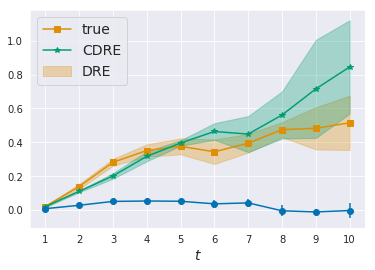

In [284]:

plt.errorbar(T,true_divs.mean(axis=0),yerr=true_divs.std(axis=0),color=cmp[0],marker=markers[0]) 
for i,(div_mean,div_std) in enumerate(zip(div_means,div_stds)):
    #plt.errorbar(T,kl_mean,yerr=kl_std,alpha=0.75)
    plt.plot(T,div_mean,color=cmp[i+1],marker=markers[i+1])
    plt.fill_between(T,div_mean-div_std,div_mean+div_std,alpha=0.3,color=cmp[i+1])
    
#plt.errorbar(T,true_kl_mean,marker='.')
#plt.errorbar(T,kl_mean,marker='.')
#plt.legend([r'$KL^{*}$',r'${KL}_{cdre}:\lambda_c=200$',r'${KL}_{cdre}:\lambda_c=100$',r'${KL}_{cdre}:\lambda_c=10$'],fontsize=14)
plt.legend(['true',r'CDRE',r'DRE'],fontsize=14,loc=2)
plt.xlabel(r'$t$',fontsize=14)
#plt.ylabel(div_type,fontsize=14)
#plt.ylabel(r'Pearson-$\chi^2$ divergence',fontsize=12)
plt.xticks(T)
#plt.savefig('../vis_results/d100_Hg_chi.pdf')

In [33]:
import tensorflow as tf

<Container object of 3 artists>

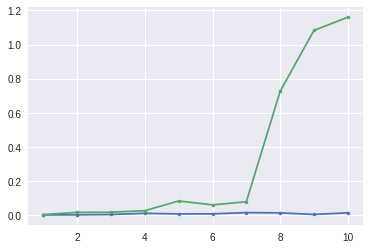

In [18]:
T = np.arange(1,len(true_kl_mean)+1)
#plt.errorbar(T,true_kl_mean,yerr=true_kl_std,marker='.')
#plt.errorbar(T,kl_mean,yerr=kl_std,marker='.')
plt.errorbar(T,true_kl_std,marker='.')
plt.errorbar(T,kl_std,marker='.')

In [162]:
true_tv_mean = np.mean(data[:,5,:],axis=0)
true_tv_std = np.std(data[:,5,:],axis=0)
tv_mean = np.mean(data[:,6,:],axis=0)
tv_std = np.std(data[:,6,:],axis=0)

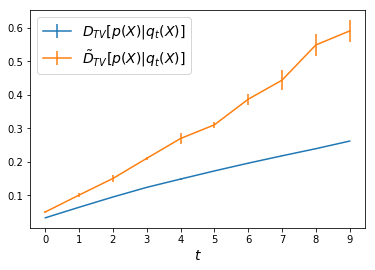

In [163]:
plt.errorbar(np.arange(len(true_tv_mean)),true_tv_mean,yerr=true_tv_std)
plt.errorbar(np.arange(len(tv_mean)),tv_mean,yerr=tv_std)
plt.legend([r'$D_{TV}[p(X)|q_t({X})]$',r'$\tilde{D}_{TV}[p(X)|q_t({X})]$'],fontsize=14)
plt.xlabel(r'$t$',fontsize=14)
plt.xticks(np.arange(len(tv_mean)))
plt.savefig(path+'tv_compare.pdf')

In [164]:
true_chi_mean = np.mean(data[:,7,:],axis=0)
true_chi_std = np.std(data[:,7,:],axis=0)
chi_mean = np.mean(data[:,8,:],axis=0)
chi_std = np.std(data[:,8,:],axis=0)

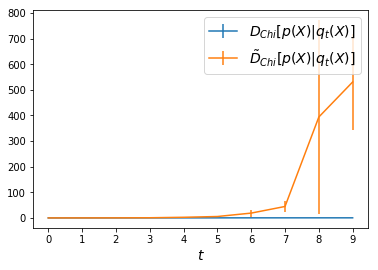

In [165]:
plt.errorbar(np.arange(len(true_chi_mean)),true_chi_mean,yerr=true_chi_std)
plt.errorbar(np.arange(len(chi_mean)),chi_mean,yerr=chi_std)
plt.legend([r'$D_{Chi}[p(X)|q_t({X})]$',r'$\tilde{D}_{Chi}[p(X)|q_t({X})]$'],fontsize=14)
plt.xlabel(r'$t$',fontsize=14)
plt.xticks(np.arange(len(chi_mean)))
plt.savefig(path+'Chi_compare.pdf')

In [15]:
prf = '/home/yu/gits/bayes_cl/dre/results/'
paths = ['wgan/cvae1','wgangp/cvae1','JS/cvae1','rvKL/cvae1']
#paths = ['wgan/fashion/cvae2','wgangp/fashion/cvae2','JS/fashion/cvae2','rvKL/fashion/cvae2']
#paths = ['cond_cl_ratio_test_d784_mnist_wgan_s6000_5seeds_v2','JS/vae','cond_cl_ratio_test_d784_mnist_rvKL_s6000_5seeds','cond_cl_ratio_test_dvae_l1e-14_d64_mnist_wgan_s6000_5seeds','cond_cl_ratio_test_dvae_l1e-14_d64_mnist_JS_s6000_5seeds','cond_cl_ratio_test_dvae_l1e-14_d64_mnist_rvKL_s6000_5seeds']
#paths = ['cl_ratio_test_d100_delta002_s10000_5seeds','cl_ratio_test_d100_delta002_5seeds','cl_ratio_test_d100_s10000_non_continual_5seeds','cl_ratio_test_d100_s50000_non_continual_5seeds']
#paths = ['cl_ratio_test_d2_delta005_s10000_5seeds','cl_ratio_test_d2_delta005_5seeds','cl_ratio_test_d2_s10000_non_continual_5seeds','cl_ratio_test_d2_s50000_non_continual_5seeds']

In [16]:
paths = [prf+p+'/' for p in paths]
data = aggregate_paths(paths)

cond_cl_ratio_test_d784_sd6_Fri-May-17-162034-2019
cond_cl_ratio_test_d784_sd4_Thu-May-16-080507-2019
cond_cl_ratio_test_d784_sd2_Thu-May-16-080507-2019
cond_cl_ratio_test_d784_sd8_Fri-May-17-162034-2019
cond_cl_ratio_test_d784_sd3_Thu-May-16-080507-2019
cond_cl_ratio_test_d784_sd5_Fri-May-17-162034-2019
cond_cl_ratio_test_d784_sd0_Thu-May-16-080507-2019
cond_cl_ratio_test_d784_sd9_Fri-May-17-162034-2019
cond_cl_ratio_test_d784_sd7_Fri-May-17-162034-2019
cond_cl_ratio_test_d784_sd1_Thu-May-16-080507-2019
cond_cl_ratio_test_d784_sd5_Fri-May-17-010542-2019
cond_cl_ratio_test_d784_sd9_Fri-May-17-010542-2019
cond_cl_ratio_test_d784_sd4_Thu-May-16-043103-2019
cond_cl_ratio_test_d784_sd1_Thu-May-16-043103-2019
cond_cl_ratio_test_d784_sd9_Fri-May-17-010532-2019
cond_cl_ratio_test_d784_sd5_Fri-May-17-010532-2019
cond_cl_ratio_test_d784_sd0_Thu-May-16-043103-2019
cond_cl_ratio_test_d784_sd3_Thu-May-16-043103-2019
cond_cl_ratio_test_d784_sd2_Thu-May-16-043103-2019
cond_cl_ratio_test_d784_sd7_Fri

In [17]:
len(data)

4

In [18]:
kls = []
for d in data:
    true_kl_mean,true_kl_std,kl_mean,kl_std = get_divergence(d,type='kl')
    kls.append([true_kl_mean,true_kl_std,kl_mean,kl_std])

In [19]:
true_kl_mean,true_kl_std = kls[0][0],kls[0][1]

In [53]:
div_type = 'Jensen_Shannon'
div_means, div_stds, true_divs = cal_div_by_ratio(div_type,paths,T=10)

/home/yu/gits/bayes_cl/dre/results/wgan/cvae1/
cond_cl_ratio_test_d784_sd6_Fri-May-17-162034-2019
cond_cl_ratio_test_d784_sd4_Thu-May-16-080507-2019
cond_cl_ratio_test_d784_sd2_Thu-May-16-080507-2019
cond_cl_ratio_test_d784_sd8_Fri-May-17-162034-2019
cond_cl_ratio_test_d784_sd3_Thu-May-16-080507-2019
cond_cl_ratio_test_d784_sd5_Fri-May-17-162034-2019
cond_cl_ratio_test_d784_sd0_Thu-May-16-080507-2019
cond_cl_ratio_test_d784_sd9_Fri-May-17-162034-2019
cond_cl_ratio_test_d784_sd7_Fri-May-17-162034-2019
cond_cl_ratio_test_d784_sd1_Thu-May-16-080507-2019
/home/yu/gits/bayes_cl/dre/results/wgangp/cvae1/
cond_cl_ratio_test_d784_sd5_Fri-May-17-010542-2019
cond_cl_ratio_test_d784_sd9_Fri-May-17-010542-2019
cond_cl_ratio_test_d784_sd4_Thu-May-16-043103-2019
cond_cl_ratio_test_d784_sd1_Thu-May-16-043103-2019
cond_cl_ratio_test_d784_sd9_Fri-May-17-010532-2019
cond_cl_ratio_test_d784_sd5_Fri-May-17-010532-2019
cond_cl_ratio_test_d784_sd0_Thu-May-16-043103-2019
cond_cl_ratio_test_d784_sd3_Thu-May-1

In [54]:
true_kl_mean,true_kl_std = np.mean(true_divs,axis=0),np.std(true_divs,axis=0)

In [55]:
kls = [ms for ms in zip(div_means,div_stds)]

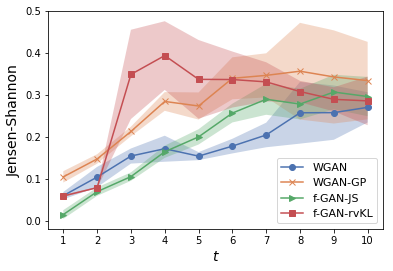

In [58]:
T = np.arange(1,len(true_kl_mean)+1)
markers=['-o','-x','->','-s','-<','-*','-^']
sn.set_palette("deep")
#plt.plot(T,true_kl_mean)
#plt.plot(T,np.zeros(len(T)))
for i in range(len(data)):
    #plt.errorbar(T,kls[i][2],yerr=kls[i][3],uplims=True, lolims=True)
    plt.fill_between(T,kls[i][0]-kls[i][1],kls[i][0]+kls[i][1],alpha=0.3)
    plt.plot(T,kls[i][0],markers[i],markersize=6)
    #plt.errorbar(T,kls[i][0],yerr=kls[i][1],uplims=True, lolims=True)
    #plt.errorbar(T,kls[i][2],marker='.')
#plt.legend([r'$KL^*$',r'${KL}_{cdre},n_s=10000$',r'${KL}_{cdre},n_s=50000$',r'${KL}_{dre},n_s=10000$',r'${KL}_{dre},n_s=50000$'],fontsize=14)
plt.legend([r'WGAN',r'WGAN-GP',r'f-GAN-JS',r'f-GAN-rvKL'],fontsize=11,loc=4)
plt.xlabel(r'$t$',fontsize=14)
#plt.ylim(0,2.25)
#plt.ylabel(r'$MAE$',fontsize=14)
plt.ylabel(r'Jensen-Shannon',fontsize=14)
plt.xticks(T)
plt.savefig('../vis_results/JS_compare_mnist_continual_m4_5seeds.pdf')

In [15]:
prf = '/home/yu/gits/bayes_cl/model_test/results/prd_half_convclss_d64/fashion/'#'/home/yu/gits/bayes_cl/model_test/results/fid_conv_d64/'#'./results/prd_d784/mnist/batch_train/prd_test_mnist_noise/'#
out_path = './results/prd_d784/fashion/'
stype='prd_half'
dim = 64
models = ['WGAN','WGANGP','rvKL','JS']#['JS']#
dataset = 'fashion'
#paths=['data','rev']
paths = [stype+'_test_'+dataset+'_'+m+'_d'+str(dim)+'_5seeds' for m in models]#['f50_nd1_5seeds/','f5_nd40_5seeds/']#
#paths = ['fid_test_fashion_WGAN_d64_5seeds','fid_test_fashion_WGANGP_d64_5seeds','fid_test_fashion_JS_d64_5seeds','fid_test_fashion_rvKL_d64_5seeds']#['fid_wgan_d1024','fid_wgangp_d1024','fid_JS_d1024','fid_rvKL_d1024']
#paths = ['fid_test_mnist_WGAN_d64_5seeds','fid_test_mnist_WGANGP_d64_5seeds','fid_test_mnist_JS_d64_5seeds','fid_test_mnist_rvKL_d64_5seeds']
paths = [prf+c+'/'+p+'/' for p in paths for c in ['task8']]#[os.path.join(prf,p) for p in paths]#[prf+p+'/' for p in paths]##
data = aggregate_paths(paths,ftype=stype,file_id=np.arange(2))


prd_half_test_FASHION_WGAN_singleSun-Jan-10-084223-2021
prd_half_test_FASHION_WGANGP_singleSun-Jan-10-084352-2021
prd_half_test_FASHION_rvKL_singleSun-Jan-10-084053-2021
prd_half_test_FASHION_JS_singleSun-Jan-10-083919-2021


In [16]:
len(prd_data[0][0])

NameError: name 'prd_data' is not defined

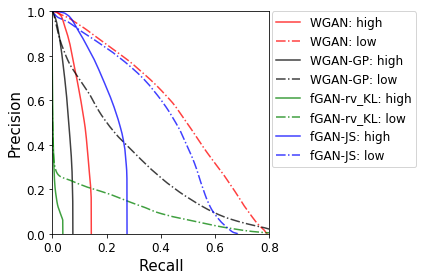

In [18]:
if  'prd' == stype:
    prd_data = [(data[i][0][0],data[i][0][1]) for i in range(len(data))]
    fig = plt.figure(figsize=(4.6, 4.6))
    for k,(prec,rec) in enumerate(prd_data):
            plt.plot(rec,prec,c=colors[k],alpha=0.75)
    #prd.plot(prd_data,labels=['WGAN','WGAN-GP','f-GAN-JS','f-GAN-rvKL'],out_path=prf+'prd.pdf')
    #prd.plot(prd_data,labels=['f-GAN-JS (stat.)','f-GAN-JS (cont.)'],out_path=prf+'prd.pdf')
    #prd.plot(prd_data,out_path=prf+'prd.pdf')
    plt.legend(['WGAN','WGAN-GP','fGAN-rv_KL','fGAN-JS'],loc=(1.01,0.7))
    plt.xlabel('Recall',fontsize=15)
    plt.ylabel('Precision',fontsize=15)
    plt.savefig(prf+stype+'_allm_100bins.pdf',bbox_inches='tight')
    
elif stype in ['prd_seg','prd_half']:
    colors = ['r','k','g','b']
    lstyle = ['-','-.','--',':']
    #fig = plt.figure(figsize=(4.6, 4.6))
    for m in range(len(data)):
        prd_data = [(data[m][i][0],data[m][i][1]) for i in range(len(data[0]))]
        #prd.plot(prd_data,labels=['WGAN','WGAN-GP','f-GAN-JS','f-GAN-rvKL'],out_path=prf+'prd.pdf')
        #prd.plot(prd_data,labels=['f-GAN-JS (stat.)','f-GAN-JS (cont.)'],out_path=prf+'prd.pdf')
        #prd.plot(prd_data,out_path=prf+'prd.pdf')
        for k,(prec,rec) in enumerate(prd_data):
            plt.plot(rec,prec,c=colors[m],alpha=0.75,linestyle=lstyle[k])
            #plt.fill(rec,prec,c=colors[m],alpha=0.25)
    plt.legend(['WGAN: high','WGAN: low','WGAN-GP: high','WGAN-GP: low','fGAN-rv_KL: high','fGAN-rv_KL: low','fGAN-JS: high','fGAN-JS: low'],fontsize=12,loc=(1.01,0.3))
    #plt.legend(['fGAN-JS(s.t.): high','fGAN-JS(s.t.): low','fGAN-JS(c.t.): high','fGAN-JS(c.t.): low','fGAN-JS(c.t.): p1','fGAN-JS(c.t.): p2','fGAN-JS(c.t.): p3','fGAN-JS(c.t.): p4'],fontsize=12,loc=(0.45,0.7))

    plt.xlabel('Recall',fontsize=15)
    plt.ylabel('Precision',fontsize=15)
    plt.xlim([0, .8])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.savefig(prf+stype+'_allm_half_100bins_t8.pdf',bbox_inches='tight')

In [78]:
fid_means, fid_stds = [], []
for d in data:
    fid_mean = np.mean(d,axis=0)
    fid_std = np.std(d,axis=0)
    fid_means.append(fid_mean)
    fid_stds.append(fid_std)

In [79]:
fid_means,fid_stds

([array([2.2750088 , 1.276781  , 2.50387601, 3.95109529, 5.5306757 ,
         6.86020612, 7.74454531, 8.58406485, 9.18353907, 8.89445714]),
  array([ 2.14681574,  3.12415126,  4.23201658,  8.92792718, 11.64852704,
         11.11859604, 12.56523727, 11.14510926, 13.017424  , 12.4833416 ]),
  array([1.68360877, 0.99606073, 1.55836437, 1.50189654, 1.56054792,
         1.31083465, 1.35986206, 1.35128462, 1.19778385, 1.08288871]),
  array([ 0.72504315,  1.09906968,  9.58531341,  8.7442818 , 11.11186376,
         10.68922989, 10.36901871,  9.29604623,  8.30021476,  7.64456715])],
 [array([0.00703458, 0.00326441, 0.00244874, 0.00580146, 0.00300264,
         0.0035239 , 0.00366996, 0.00650914, 0.00515184, 0.00206532]),
  array([0.00650053, 0.00565535, 0.00288947, 0.00940558, 0.00647156,
         0.00457445, 0.00458407, 0.00792392, 0.00561611, 0.00291917]),
  array([0.00467321, 0.00199099, 0.00225569, 0.00264053, 0.00171321,
         0.00125156, 0.0013119 , 0.00246442, 0.00193735, 0.00113605]),

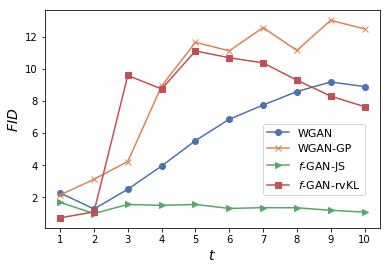

In [82]:
T = np.arange(1,len(fid_means[0])+1)
markers=['-o','-x','->','-s','-<','-*','-^']
for i in range(len(data)):
    plt.plot(T,fid_means[i],markers[i],markersize=6)
    plt.fill_between(T,fid_means[i]-fid_stds[i],fid_means[i]+fid_stds[i],alpha=0.25)
    #plt.errorbar(T,fid_means[i],yerr=fid_stds[i],uplims=True, lolims=True)
plt.legend(['WGAN','WGAN-GP',r'$f$-GAN-JS',r'$f$-GAN-rvKL'],fontsize=11,loc=(0.65,0.15))
if stype == 'fid':
    plt.ylabel(r'$FID$',fontsize=14)
elif stype == 'kid':
    plt.ylabel(r'$KID$',fontsize=14)
#plt.ylim(-0.000003,0.000015)
plt.xticks(T)
plt.xlabel(r'$t$',fontsize=14)
plt.savefig('../vis_results/'+stype+'_mnist_comparison_dim'+str(dim)+'_convclss_m4_5seeds.pdf')

In [202]:
current_palette = sn.color_palette()

In [203]:
current_palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

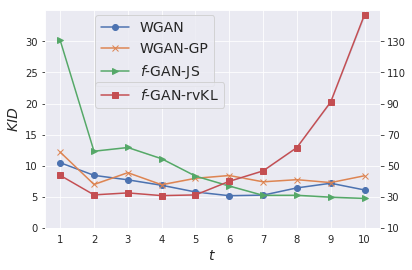

In [205]:
T = np.arange(1,len(fid_means[0])+1)
markers=['-o','-x','->','-s','-<','-*','-^']
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for i in range(len(data)):
    if i < 3:
        ax1.plot(T,fid_means[i],markers[i],markersize=6)
        ax1.fill_between(T,fid_means[i]-fid_stds[i],fid_means[i]+fid_stds[i],alpha=0.25)
    else:
        ax2.plot(T,fid_means[i],markers[i],color=current_palette[3],markersize=6)
        ax2.fill_between(T,fid_means[i]-fid_stds[i],fid_means[i]+fid_stds[i],alpha=0.25)
    #plt.errorbar(T,fid_means[i],yerr=fid_stds[i],uplims=True, lolims=True)

if stype == 'fid':
    ax1.set_ylabel(r'$FID$',fontsize=14)
elif stype == 'kid':
    ax1.set_ylabel(r'$KID$',fontsize=14)
ax1.set_ylim(0.,35)
ax1.set_yticks(np.arange(0,35,5))
ax2.set_ylim(10.,150)
ax2.set_yticks(np.arange(10,150,20))

ax1.legend(['WGAN','WGAN-GP',r'$f$-GAN-JS'],fontsize=14,loc=(0.15,0.65))
ax2.legend([r'$f$-GAN-rvKL'],fontsize=14,loc=(0.15,0.55))
ax2.grid(False)
plt.xticks(T)
ax1.set_xlabel(r'$t$',fontsize=14)
plt.savefig('../vis_results/'+stype+'_fashion_comparison_dim'+str(dim)+'_convclss_m4_5seeds.pdf')
#plt.savefig('./results/aggregates/'+stype+'_fashion_comparison_dim'+str(dim)+'_convclss_m4_5seeds.pdf')

In [88]:
prf = '../model_test/results/split_mnist_convclss_d64/split/rvkl/'
stype='kl'
dim = 64
models = ['WGAN','WGANGP','JS','rvKL']
dataset = 'mnist'
paths = ['rev']
#paths = [stype+'_test_'+dataset+'_'+m+'_d'+str(dim)+'_5seeds' for m in models]
#paths = ['fid_test_mnist_WGAN_d64_5seeds','fid_test_mnist_WGANGP_d64_5seeds','fid_test_mnist_JS_d64_5seeds','fid_test_mnist_rvKL_d64_5seeds']#['fid_wgan_d1024','fid_wgangp_d1024','fid_JS_d1024','fid_rvKL_d1024']
#paths = ['kid_test_mnist_WGAN_d512_5seeds','kid_test_mnist_WGANGP_d512_5seeds','kid_test_mnist_JS_d512_5seeds','kid_test_mnist_rvKL_d512_5seeds']
paths = [prf+p+'/' for p in paths]
data = aggregate_paths(paths,ftype=stype)

kl_test_MNIST_rev_splitWed-May-22-121644-2019
kl_test_MNIST_rev_splitWed-May-22-122110-2019
kl_test_MNIST_rev_splitWed-May-22-121530-2019
kl_test_MNIST_rev_splitWed-May-22-121808-2019
kl_test_MNIST_rev_splitWed-May-22-121940-2019


In [89]:
score_means, score_stds = [], []
for d in data:
    score_mean = np.mean(d)
    score_std = np.std(d)
    score_means.append(score_mean)
    score_stds.append(score_std)

In [90]:
data

[array([[ 81.87407684],
        [ 82.14892578],
        [ 80.6271286 ],
        [ 78.52101135],
        [ 73.12002563]])]

In [91]:
score_means,score_stds

([79.258233642578119], [3.32546851888999])

In [92]:
save_r = pd.DataFrame()
save_r['mean'] = score_means
save_r['std'] = score_stds
save_r.to_csv(prf+'score.csv',index=False)

([<matplotlib.axis.XTick at 0x7f40f789f190>,
 <a list of 4 Text xticklabel objects>)

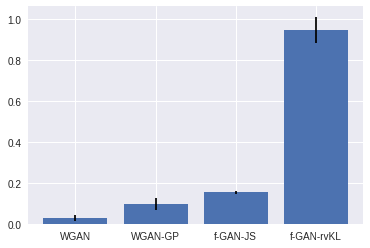

In [51]:
x_ax = np.arange(len(data))
plt.bar(x_ax,score_means,yerr=score_stds)
plt.xticks(x_ax,['WGAN','WGAN-GP','f-GAN-JS','f-GAN-rvKL'])

([<matplotlib.axis.XTick at 0x7f284c491d50>,
 <a list of 4 Text xticklabel objects>)

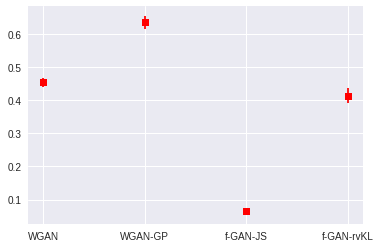

In [369]:
plt.errorbar(x_ax,score_means,yerr=score_stds,fmt='rs')
plt.xticks(x_ax,['WGAN','WGAN-GP','f-GAN-JS','f-GAN-rvKL'])

In [15]:
def read_scores(paths,div_type=None):
    score_means = []
    score_stds = []
    for p in paths:
        if div_type is None or div_type=='kl':
            s = pd.read_csv(p+'score.csv')
        else:
            s = pd.read_csv(p+div_type+'.csv')
        
        score_means.append(s['mean'].values)
        score_stds.append(s['std'].values)
    return score_means, score_stds

In [165]:
root = '../model_test/results/kl_convclss_d64/mnist/task9/'
dataset = 'mnist'
types = ['kl']#['fid','kid','kl']
div_type = 'Jensen_Shannon'
ps = ['_conv_vae_d64/mnist/']#['_convclss_d64/mnist/','_vae_d64/mnist/']
models = ['batch_train/','task9/']
paths = []
for t in types:    
    for p in ps:
        for m in models:
            paths.append(root+t+p+m)
means,stds = read_scores(paths,div_type=div_type)

IOError: File ../model_test/results/kl_convclss_d64/mnist/task9/kl_conv_vae_d64/mnist/batch_train/Jensen_Shannon.csv does not exist

In [47]:
fs = ['+vae']#['+clf','+vae']
#idx = [t+f for t in types for f in fs]
if div_type is not None:
    idx = [div_type+f for f in fs]
else:
    idx = [t+f for t in types for f in fs]
all_scores_mean = pd.DataFrame(index=idx,columns=['WGAN_bt','WGAN-GP_bt','f-GAN-JS_bt','f-GAN-rvKL_bt','WGAN_ct','WGAN-GP_ct','f-GAN-JS_ct','f-GAN-rvKL_ct'])
all_scores_std = pd.DataFrame(index=idx,columns=['WGAN_bt','WGAN-GP_bt','f-GAN-JS_bt','f-GAN-rvKL_bt','WGAN_ct','WGAN-GP_ct','f-GAN-JS_ct','f-GAN-rvKL_ct'])

for i,t in enumerate(idx):
        all_scores_mean.loc[t] = np.concatenate(means[i*2:(i+1)*2])
        all_scores_std.loc[t] = np.concatenate(stds[i*2:(i+1)*2])

In [48]:
all_scores_mean

,WGAN_bt,WGAN-GP_bt,f-GAN-JS_bt,f-GAN-rvKL_bt,WGAN_ct,WGAN-GP_ct,f-GAN-JS_ct,f-GAN-rvKL_ct
fid+vae,0.00906328,0.0123431,0.0111562,0.0127033,0.0293447,0.0434089,0.0209492,0.0303925


In [49]:
all_scores_std

,WGAN_bt,WGAN-GP_bt,f-GAN-JS_bt,f-GAN-rvKL_bt,WGAN_ct,WGAN-GP_ct,f-GAN-JS_ct,f-GAN-rvKL_ct
fid+vae,7.78796e-05,0.000102027,0.000134753,0.000113856,0.000114369,0.000240489,0.000184854,0.000250118


In [651]:
tot_means = pd.read_csv('../dre/results/aggregates/'+dataset+'_single_all_scores_mean.csv',index_col=0)
tot_means = tot_means.append(all_scores_mean)
tot_stds = pd.read_csv('../dre/results/aggregates/'+dataset+'_single_all_scores_std.csv',index_col=0)
tot_stds = tot_stds.append(all_scores_std)

In [652]:
tot_means

,WGAN_bt,WGAN-GP_bt,f-GAN-JS_bt,f-GAN-rvKL_bt,WGAN_ct,WGAN-GP_ct,f-GAN-JS_ct,f-GAN-rvKL_ct
fid+clf,1.58555,5.33811,1.46908,1.67822,9.001,12.6238,1.20269,7.8995
fid+vae,0.00579913,0.0076312,0.00653233,0.00630527,0.0105802,0.0160538,0.0105962,0.0101496
kid+clf,0.0842215,0.294061,0.0793757,0.0906581,0.454021,0.635054,0.0649085,0.414042
kid+vae,3.97541e-05,0.000133882,7.83641e-05,6.3642e-05,0.000111814,0.000251575,0.000115736,0.000109155
kl+clf,0.284372,1.70969,0.708487,1.10318,2.85305,6.44557,1.51413,6.2687
kl+vae,0.0318552,0.0753537,0.0509404,0.0417821,0.321955,2.69245,0.0495816,1.94251
Jensen_Shannon+clf,0.857943,1.01865,0.950912,1.16672,1.01176,1.30599,0.844321,1.37121
Jensen_Shannon+vae,0.0343041,0.0549029,0.0696652,0.334725,0.298849,0.331567,0.00699074,1.10503
Pearson+clf,10.5469,19.8341,16.3372,68.0595,97.4962,348.988,148.641,986.576
Pearson+vae,0.151195,0.259398,0.331973,5.61796,8.81377,5.84946,0.0280013,294.712


In [653]:
tot_stds

,WGAN_bt,WGAN-GP_bt,f-GAN-JS_bt,f-GAN-rvKL_bt,WGAN_ct,WGAN-GP_ct,f-GAN-JS_ct,f-GAN-rvKL_ct
fid+clf,3.65083e-13,1.99135e-13,3.1883e-13,4.48271e-13,1.6932e-13,1.62379e-13,4.15152e-13,3.75393e-13
fid+vae,6.04352e-05,6.77554e-05,7.57528e-05,6.99975e-05,4.40943e-05,4.42566e-05,5.19557e-05,7.42866e-05
kid+clf,0.00576359,0.011527,0.00751714,0.0077053,0.0139045,0.0187046,0.00838029,0.0215761
kid+vae,5.94201e-06,8.27105e-06,4.95945e-06,4.98395e-06,5.19769e-06,1.05807e-05,7.5541e-06,7.41879e-06
kl+clf,0.00584538,0.0285205,0.154608,0.0259347,0.14662,0.408179,0.138978,0.185642
kl+vae,0.00163785,0.00294647,0.00259194,0.00145296,0.125005,0.284459,0.00225116,0.146572
Jensen_Shannon+clf,0.02145,0.0141622,0.0175879,0.0252197,0.0490398,0.00779191,0.0251876,0.00562925
Jensen_Shannon+vae,0.0116031,0.00454713,0.00861779,0.023534,0.0356177,0.0336855,0.000541532,0.160724
Pearson+clf,2.78126,5.06559,5.79012,38.4656,9.35634,55.592,45.0712,10.8511
Pearson+vae,0.0537024,0.0274227,0.0487266,1.02605,1.90827,0.873834,0.00224529,170.017


In [654]:
tot_means.to_csv('../dre/results/aggregates/'+dataset+'_single_all_scores_mean.csv')
tot_stds.to_csv('../dre/results/aggregates/'+dataset+'_single_all_scores_std.csv')

In [589]:
#all_scores_mean.to_csv('../dre/results/aggregates/'+dataset+'_single_all_scores_mean.csv')
#all_scores_std.to_csv('../dre/results/aggregates/'+dataset+'_single_all_scores_std.csv')

([<matplotlib.axis.XTick at 0x7f281ea48750>,
 <a list of 4 Text xticklabel objects>)

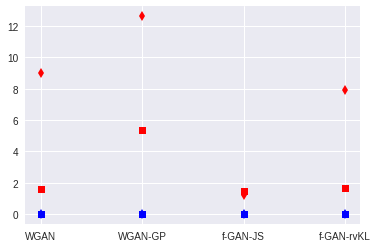

In [403]:
fmts=['rs','bs','rd','bd']
for i in range(len(means)):
    plt.errorbar(x_ax,means[i],yerr=stds[i],fmt=fmts[i])
plt.xticks(x_ax,['WGAN','WGAN-GP','f-GAN-JS','f-GAN-rvKL'])

In [404]:
means

[array([ 1.58555111,  5.33810804,  1.46907621,  1.6782181 ]),
 array([ 0.00579913,  0.0076312 ,  0.00653233,  0.00630527]),
 array([  9.00100491,  12.62381821,   1.2026872 ,   7.89949657]),
 array([ 0.01058021,  0.01605377,  0.01059618,  0.01014955])]

In [3]:
import gzip
from tensorflow.python.platform import gfile

In [86]:
import io
import struct
def extract_data(fpath,shape,dtype=np.float32):
    """Extract the images into a 4D uint8 numpy array [index, y, x, depth].
    Args:
        f: A file object that can be passed into a gzip reader.
    Returns:
        data: A numpy array [index, y, x, depth].
    Raises:
        ValueError: If the bytestream does not start with 2051.
    """
    with open(fpath, 'rb') as f:
        with gzip.GzipFile(fileobj=f) as bytestream:
            buf = bytestream.read()
            data = np.frombuffer(buf, dtype=dtype)
            data = data.reshape([-1]+shape)
        return data

In [43]:
def save_samples(path,samples,file_name=None):

    if not os.path.exists(path):
        os.makedirs(path)
    if path[-1] != '/':
        path+='/'

    if file_name is None:
        file_name = ['samples','labels']

    if not isinstance(samples,list):
        samples = [samples]

    for s,fname in zip(samples,file_name): 
        #print(s.shape)
        with gzip.open(path+fname+'.gz', 'wb') as f:
            f.write(s)

In [16]:
def read_scores(paths,div_type=None):
    scores=[]
    for p in paths:
        if div_type is None or div_type=='kl':
            s = np.loadtxt(os.path.join(p,'score.csv'),delimiter=',')
        else:
            s = np.loadtxt(os.path.join(p,div_type+'.csv'),delimiter=',')
        
        scores.append(s)
    return scores

In [44]:
compare_score_means = []
compare_score_stds = []

In [14]:
prf = './results/kl_d784/mnist/batch_train/kl_test_mnist_noise/'#'../model_test/results/kl_d2048/ffhq/batch_train/'
stype='kl'
#dim = 64
#models = ['stylegan','true']
#dataset = 'ffhq'
paths = ['f50_nd1_5seeds/','f5_nd40_5seeds/']
#paths = [stype+'_test_'+dataset+'_'+m+'_d'+str(dim)+'_5seeds/' for m in models]
#paths = ['fid_test_mnist_WGAN_d64_5seeds','fid_test_mnist_WGANGP_d64_5seeds','fid_test_mnist_JS_d64_5seeds','fid_test_mnist_rvKL_d64_5seeds']#['fid_wgan_d1024','fid_wgangp_d1024','fid_JS_d1024','fid_rvKL_d1024']
#paths = ['kid_test_mnist_WGAN_d512_5seeds','kid_test_mnist_WGANGP_d512_5seeds','kid_test_mnist_JS_d512_5seeds','kid_test_mnist_rvKL_d512_5seeds']
paths = [prf+p for p in paths]
data = aggregate_paths(paths,ftype=stype)

kl_test_mnist_noise_singleThu-Aug-15-220030-2019
kl_test_mnist_noise_singleThu-Aug-15-220522-2019
kl_test_mnist_noise_singleThu-Aug-15-221954-2019
kl_test_mnist_noise_singleThu-Aug-15-213725-2019
kl_test_mnist_noise_singleThu-Aug-15-214613-2019
kl_test_mnist_noise_singleThu-Aug-15-222258-2019
kl_test_mnist_noise_singleThu-Aug-15-223741-2019
kl_test_mnist_noise_singleThu-Aug-15-215050-2019
kl_test_mnist_noise_singleThu-Aug-15-221303-2019
kl_test_mnist_noise_singleThu-Aug-15-215512-2019
kl_test_mnist_noise_singleThu-Aug-15-231609-2019
kl_test_mnist_noise_singleThu-Aug-15-232013-2019
kl_test_mnist_noise_singleThu-Aug-15-231229-2019
kl_test_mnist_noise_singleThu-Aug-15-232217-2019
kl_test_mnist_noise_singleThu-Aug-15-231800-2019
kl_test_mnist_noise_singleThu-Aug-15-231408-2019
kl_test_mnist_noise_singleThu-Aug-15-223905-2019
kl_test_mnist_noise_singleThu-Aug-15-222822-2019
kl_test_mnist_noise_singleThu-Aug-15-232644-2019
kl_test_mnist_noise_singleThu-Aug-15-232414-2019


In [56]:
score_means, score_stds = [], []
for d in data:
    score_mean = np.mean(d)
    score_std = np.std(d)
    score_means.append(score_mean)
    score_stds.append(score_std)

In [57]:
score_means,score_stds

([0.020015331171453, 0.021145321428775787],
 [0.002155112987873048, 0.0018154873804916598])

In [58]:

compare_score_means.append(score_means)
compare_score_stds.append(score_stds)

In [59]:
compare_score_means,compare_score_stds

([[0.2006077523635895, 0.16229250516036017],
  [0.11915915218418405, 0.013726855863961874],
  [0.020015331171453, 0.021145321428775787]],
 [[1.5294999748146515e-13, 1.1138989729374156e-13],
  [0.037725373902018085, 0.025279463666787794],
  [0.002155112987873048, 0.0018154873804916598]])

In [60]:
compare_score_means = np.vstack(compare_score_means)
compare_score_stds = np.vstack(compare_score_stds)

In [20]:
width = 0.3
x_ax = np.arange(len(compare_score_means))
plt.bar(x_ax,compare_score_means[:,0],yerr=compare_score_stds[:,0],width=width)
plt.bar(x_ax+width,compare_score_means[:,1],yerr=compare_score_stds[:,1],width=width)
#plt.xticks(x_ax + width/2, ('FID', 'KID', 'KL'))
plt.legend(['dense noise','sparse noise'])
#plt.savefig('./results/aggregates/compare_score_noise_mnist.pdf')

NameError: name 'compare_score_means' is not defined

In [17]:
divs = ['KL','rv_KL','Jensen_Shannon','Hellinger']
scores = {}
for div_type in divs:
    for pt in paths:
        sd = os.listdir(pt)
        spth = []
        for s in sd:
            print(s)
            s = os.path.join(pt,s)
            spth.append(s)
            r = np.loadtxt(s+'/sample_ratios.csv',delimiter=',')
            div = calc_divgenerce(div_type,[r])
            np.savetxt(X=div,fname=os.path.join(s,div_type+'.csv'))
        sc = scores.get(div_type,[])
        sc.append(read_scores(spth,div_type))
        scores[div_type] = sc

kl_test_mnist_noise_singleThu-Aug-15-220030-2019
kl_test_mnist_noise_singleThu-Aug-15-220522-2019
kl_test_mnist_noise_singleThu-Aug-15-221954-2019
kl_test_mnist_noise_singleThu-Aug-15-213725-2019
kl_test_mnist_noise_singleThu-Aug-15-214613-2019
kl_test_mnist_noise_singleThu-Aug-15-222258-2019
kl_test_mnist_noise_singleThu-Aug-15-223741-2019
kl_test_mnist_noise_singleThu-Aug-15-215050-2019
kl_test_mnist_noise_singleThu-Aug-15-221303-2019
kl_test_mnist_noise_singleThu-Aug-15-215512-2019
kl_test_mnist_noise_singleThu-Aug-15-231609-2019
kl_test_mnist_noise_singleThu-Aug-15-232013-2019
kl_test_mnist_noise_singleThu-Aug-15-231229-2019
kl_test_mnist_noise_singleThu-Aug-15-232217-2019
kl_test_mnist_noise_singleThu-Aug-15-231800-2019
kl_test_mnist_noise_singleThu-Aug-15-231408-2019
kl_test_mnist_noise_singleThu-Aug-15-223905-2019
kl_test_mnist_noise_singleThu-Aug-15-222822-2019
kl_test_mnist_noise_singleThu-Aug-15-232644-2019
kl_test_mnist_noise_singleThu-Aug-15-232414-2019
kl_test_mnist_noise_

In [18]:
stats = {}
for div,sc in six.iteritems(scores):
    print(div)
    stats[div] = {}
    stats[div]['mean'] = [np.mean(s) for s in sc]
    stats[div]['std'] = [np.std(s) for s in sc]
    print([(np.mean(s),np.std(s)) for s in sc])

KL
[(0.02001533091301691, 0.002155113348087199), (0.02114532152816192, 0.0018154870037613347)]
rv_KL
[(0.021402665174623782, 0.0025565640156501833), (0.03395048689928244, 0.004717811861262783)]
Jensen_Shannon
[(0.010245300027900469, 0.0011441446203955678), (0.01241822047310422, 0.0012276039377378523)]
Hellinger
[(0.010299030802326727, 0.0011605166784390936), (0.013024609573481524, 0.0013985062387767034)]


In [6]:
fid_p = './results/fid_d784/mnist/batch_train/fid_test_mnist_noise/'
kid_p = './results/kid_d784/mnist/batch_train/kid_test_mnist_noise/'
kl_p = './results/kl_d784/mnist/batch_train/kl_test_mnist_noise/'

sub_f = ['f50_nd1_5seeds/','f5_nd40_5seeds/']
lgds = ['dense noise','sparse noise']

score_path = {'fid':[fid_p + f for f in sub_f],'kid':[kid_p+f for f in sub_f], \
              'kl':[kl_p+f for f in sub_f], 'rv_KL':[kl_p+f for f in sub_f]}

fid_test_mnist_noise_singleFri-Aug-16-114609-2019
fid_test_mnist_noise_singleFri-Aug-16-113729-2019
fid_test_mnist_noise_singleFri-Aug-16-093620-2019
fid_test_mnist_noise_singleFri-Aug-16-120323-2019
fid_test_mnist_noise_singleFri-Aug-16-115113-2019
fid_test_mnist_noise_singleFri-Aug-16-114303-2019
fid_test_mnist_noise_singleFri-Aug-16-113043-2019
fid_test_mnist_noise_singleFri-Aug-16-112806-2019
fid_test_mnist_noise_singleFri-Aug-16-113438-2019
fid_test_mnist_noise_singleFri-Aug-16-112519-2019
fid_test_mnist_noise_singleFri-Aug-16-112741-2019
fid_test_mnist_noise_singleFri-Aug-16-114236-2019
fid_test_mnist_noise_singleFri-Aug-16-093557-2019
fid_test_mnist_noise_singleFri-Aug-16-113413-2019
fid_test_mnist_noise_singleFri-Aug-16-113017-2019
fid_test_mnist_noise_singleFri-Aug-16-114544-2019
fid_test_mnist_noise_singleFri-Aug-16-112454-2019
fid_test_mnist_noise_singleFri-Aug-16-120258-2019
fid_test_mnist_noise_singleFri-Aug-16-115047-2019
fid_test_mnist_noise_singleFri-Aug-16-113705-2019


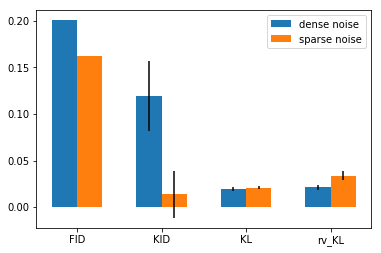

In [10]:
plot_static_scores(score_path, xticks=['FID','KID','KL','rv_KL','JS'],legends=lgds,save_path='./results/aggregates/compare_score_noise_mnist_convcls_d64.pdf')

In [8]:
prd_p = './results/prd_d784/mnist/batch_train/prd_test_mnist_noise/'
paths = [prd_p+f for f in sub_f]

In [10]:
plot_prd_scores(paths,save_path=prd_p+'prd_compare.pdf',legends=lgds)

prd_test_mnist_noise_singleMon-Aug-19-232022-2019
prd_test_mnist_noise_singleMon-Aug-19-231846-2019


In [6]:
import scipy as sp
from utils.test_util import Gaussian_KL, get_dists

In [7]:
def r(x,p2_loc=0.2,p2_scale=1.):
    return sp.stats.norm.pdf(x)/sp.stats.norm.pdf(x,loc=p2_loc,scale=p2_scale)

In [8]:
def T(x):
    return np.vstack([x**2,x]).transpose()

In [9]:
def cov(x):
    return np.cov(x,rowvar=False)

In [10]:
def E(x):
    return np.diag(np.mean(x,axis=0))

In [11]:
p1_samples = np.random.normal(loc=0.,scale=1.,size=200000)

In [12]:
def nu2(p1_samples,p2_loc=0.2,p2_scale=1.):
    Tx = T(p1_samples)
    icov = np.linalg.inv(cov(Tx))
    Erx = E(r(p1_samples,p2_loc,p2_scale).reshape(-1,1)*Tx*Tx)
    Ex2 = E(Tx)**2
    nu2 = icov+icov*icov*(Erx-Ex2)
    return nu2

In [13]:
Tx=T(p1_samples)

In [14]:
cov(Tx)

array([[1.98418437, 0.00210823],
       [0.00210823, 0.9954541 ]])

In [15]:
KL=[]
NU=[]
for i in range(21):
    delta = 0.1
    p2_loc, p2_scale = delta*i, 1.
    nu_dist,de_dist = get_dists(1,0.,1.,p2_loc,p2_scale)
    kl = Gaussian_KL(dim=1,dist_a=nu_dist,dist_b=de_dist)
    KL.append(kl)
    NU.append(np.diag(nu2(p1_samples,p2_loc,p2_scale)))

In [16]:
NU = np.vstack(NU)

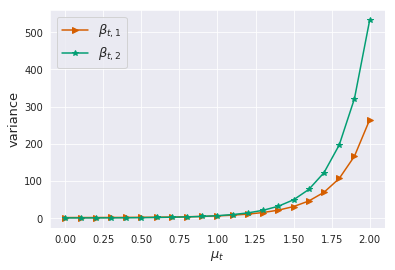

In [17]:
sn.set_style('darkgrid')
k = np.arange(len(KL))
cmp = sn.color_palette("colorblind")
plt.plot(k*0.1,NU[:,1],'->',color=cmp[3])
plt.plot(k*0.1,NU[:,0],'-*',color=cmp[2])
#plt.plot(k,k*0.1,'-*',color=cmp[0])

plt.legend([r'$\beta_{t,1}$',r'$\beta_{t,2}$'],fontsize=13)
plt.xlabel('$\mu_t$',fontsize=13)
#plt.xlabel(r'$\mathcal{D}_{KL}(q_{t-1}||q_t)$',fontsize=13)
plt.ylabel(r'variance',fontsize=13)
plt.savefig('../vis_results/theorem_demo.pdf')

In [77]:
KL

[0.0,
 0.0050000000000000044,
 0.020000000000000018,
 0.04500000000000004,
 0.08000000000000007,
 0.125,
 0.18000000000000005,
 0.2450000000000001,
 0.32000000000000006,
 0.405,
 0.5,
 0.605,
 0.7200000000000002,
 0.8450000000000002,
 0.9800000000000002,
 1.125,
 1.2800000000000002,
 1.4450000000000003,
 1.62,
 1.8050000000000002,
 2.0]

In [45]:
x = np.linspace(start=-5.,stop=7.,num=100)
#x = np.linspace(start=-5.,stop=7.,num=100)
y0 = sp.stats.norm.pdf(x,loc=0.,scale=1.)
y1 = sp.stats.norm.pdf(x,loc=1.,scale=1.)
y2 = sp.stats.norm.pdf(x,loc=1.5,scale=1.)
y3 = sp.stats.norm.pdf(x,loc=2.,scale=1.)

In [5]:
plt.plot(x,y0,'-')
plt.plot(x,y1,'-.')
plt.plot(x,y2,'-.')
plt.plot(x,y3,'-.')
plt.legend(['$q_{t-1}$','$q_t: KL=0.5$','$q_t: KL=1.13$','$q_t: KL=2$'])
plt.xlabel('x')
plt.ylabel('probability of x')
plt.savefig('../vis_results/theorem_demo_dists.pdf')

NameError: name 'x' is not defined

In [53]:
KL[15]

1.125